Let's build a simple neural network to classify images from the FashionMNIST dataset.

**1. Import Libraries**

In [1]:
import os, random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

# Reproducibility (pokud chceš absolutní determinismus, vypni benchmark níže)
torch.manual_seed(42)
random.seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if device.type == 'cuda':
    # rychlejší konvoluce na GPU (malý rozdíl, ale zdarma)
    torch.backends.cudnn.benchmark = True

print(f'Using device: {device}')

Using device: cpu


*Checking for GPU Availability*

This code checks if a CUDA-enabled GPU is available and sets the `device` accordingly. If no GPU is available, it defaults to the CPU.

**2. Data Preparation**

In [2]:
class_names = ['T-shirt/top','Trouser','Pullover','Dress','Coat',
               'Sandal','Shirt','Sneaker','Bag','Ankle boot']

# Normalizační konstanty pro FashionMNIST
FM_MEAN, FM_STD = (0.2861,), (0.3530,)

transform_train = transforms.Compose([
    transforms.RandomCrop(28, padding=2),
    transforms.RandomHorizontalFlip(p=0.1),
    transforms.ToTensor(),
    transforms.Normalize(FM_MEAN, FM_STD),
    # Volitelné, ale často přidá ~0.2–0.5 p. b.:
    # transforms.RandomErasing(p=0.25, scale=(0.02, 0.15), ratio=(0.3, 3.3))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(FM_MEAN, FM_STD),
])

train_set = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform_train)
test_set  = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform_test)

use_cuda = (device.type == 'cuda')
batch_train = 128 if not use_cuda else 256
batch_test  = 256 if not use_cuda else 512

num_workers = (0 if not use_cuda else min(4, max(2, os.cpu_count()//4)))
pin_mem = use_cuda
persist = use_cuda and num_workers > 0

train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=batch_train, shuffle=True,
    num_workers=num_workers, pin_memory=pin_mem, persistent_workers=persist
)
test_loader = torch.utils.data.DataLoader(
    test_set, batch_size=batch_test, shuffle=False,
    num_workers=num_workers, pin_memory=pin_mem, persistent_workers=persist
)

**3. Neural Network Model**

In [3]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            # Block 1: 28x28 -> 28x28 -> 14x14
            nn.Conv2d(1, 32, 3, padding=1, bias=False), nn.BatchNorm2d(32), nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, 3, padding=1, bias=False), nn.BatchNorm2d(32), nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  # 28 -> 14
            nn.Dropout(0.10),

            # Block 2: 14x14 -> 14x14 -> 7x7
            nn.Conv2d(32, 64, 3, padding=1, bias=False), nn.BatchNorm2d(64), nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, 3, padding=1, bias=False), nn.BatchNorm2d(64), nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  # 14 -> 7
            nn.Dropout(0.20),

            # Block 3: 7x7 -> 7x7
            nn.Conv2d(64, 128, 3, padding=1, bias=False), nn.BatchNorm2d(128), nn.ReLU(inplace=True),

            # Global Average Pooling: 7x7 -> 1x1
            nn.AdaptiveAvgPool2d(1)
        )
        self.classifier = nn.Linear(128, 10)

    def forward(self, x):
        x = self.features(x)
        x = x.flatten(1)   # [B, 128]
        return self.classifier(x)

model = SimpleCNN().to(device)
model

SimpleCNN(
  (features): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.1, inplace=False)
    (8): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (12): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): MaxPool2d(k

**4. Loss & Optimizer**

In [4]:
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

optimizer = optim.SGD(
    model.parameters(),
    lr=0.1, momentum=0.9, nesterov=True, weight_decay=5e-4
)

epochs = 12
# OneCycleLR se u malých CNN chová skvěle (step po batchi)
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=0.2,
    steps_per_epoch=len(train_loader), epochs=epochs
)

**5. Training loop**

In [5]:
scaler = torch.cuda.amp.GradScaler(enabled=(device.type == 'cuda'))

history = {'loss': [], 'acc': [], 'lrs': []}

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)

        with torch.cuda.amp.autocast(enabled=(device.type == 'cuda')):
            outputs = model(images)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        # Volitelné při nestabilitě: torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        scaler.step(optimizer)
        scaler.update()
        scheduler.step()  # OneCycleLR -> po každém batchi
        history['lrs'].append(scheduler.get_last_lr()[0])

        running_loss += loss.item()
        with torch.no_grad():
            preds = outputs.argmax(1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100.0 * correct / total
    history['loss'].append(epoch_loss)
    history['acc'].append(epoch_acc)

    print(f'Epoch [{epoch+1}/{epochs}]  Loss: {epoch_loss:.4f}  Train Acc: {epoch_acc:.2f}%')

/var/folders/pt/4rypzgx161xbyqfj39t1nrqh0000gn/T/ipykernel_15298/1623543180.py:1: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(device.type == 'cuda'))
/var/folders/pt/4rypzgx161xbyqfj39t1nrqh0000gn/T/ipykernel_15298/1623543180.py:17: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type == 'cuda')):


Epoch [1/12]  Loss: 1.1153  Train Acc: 73.63%
Epoch [2/12]  Loss: 0.8428  Train Acc: 85.69%
Epoch [3/12]  Loss: 0.7967  Train Acc: 87.80%
Epoch [4/12]  Loss: 0.7818  Train Acc: 88.54%
Epoch [5/12]  Loss: 0.7670  Train Acc: 89.27%
Epoch [6/12]  Loss: 0.7617  Train Acc: 89.45%
Epoch [7/12]  Loss: 0.7523  Train Acc: 89.79%
Epoch [8/12]  Loss: 0.7448  Train Acc: 90.20%
Epoch [9/12]  Loss: 0.7361  Train Acc: 90.59%
Epoch [10/12]  Loss: 0.7205  Train Acc: 91.28%
Epoch [11/12]  Loss: 0.6987  Train Acc: 92.22%
Epoch [12/12]  Loss: 0.6821  Train Acc: 93.08%


**6. Evaluation on the test set**

In [6]:
model.eval()
correct = 0
total = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)
        with torch.cuda.amp.autocast(enabled=(device.type == 'cuda')):
            outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_preds.extend(predicted.cpu().numpy().tolist())
        all_labels.extend(labels.cpu().numpy().tolist())

test_acc = 100.0 * correct / total
print(f'Test Accuracy: {test_acc:.2f}%')

/var/folders/pt/4rypzgx161xbyqfj39t1nrqh0000gn/T/ipykernel_15298/1773037597.py:11: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type == 'cuda')):


Test Accuracy: 92.97%


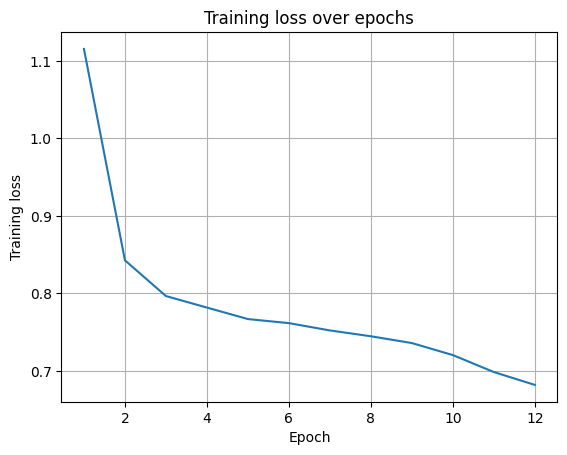

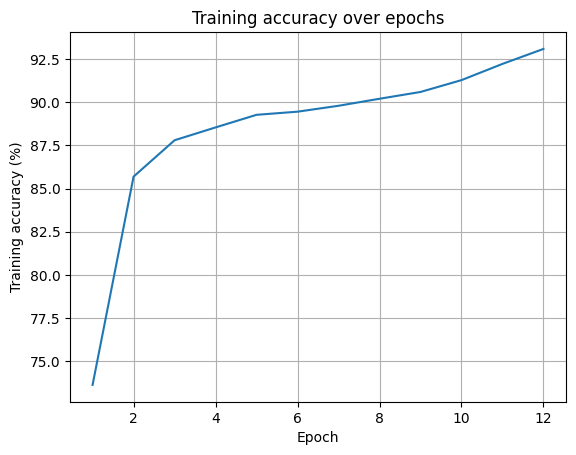

In [7]:
plt.figure()
plt.plot(range(1, epochs+1), history['loss'])
plt.xlabel('Epoch'); plt.ylabel('Training loss')
plt.title('Training loss over epochs'); plt.grid(True)
plt.show()

plt.figure()
plt.plot(range(1, epochs+1), history['acc'])
plt.xlabel('Epoch'); plt.ylabel('Training accuracy (%)')
plt.title('Training accuracy over epochs'); plt.grid(True)
plt.show()

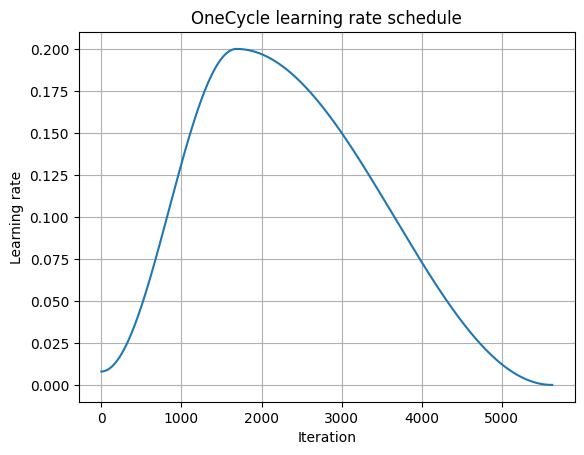

In [8]:
plt.figure()
plt.plot(range(1, len(history['lrs'])+1), history['lrs'])
plt.xlabel('Iteration'); plt.ylabel('Learning rate')
plt.title('OneCycle learning rate schedule'); plt.grid(True)
plt.show()

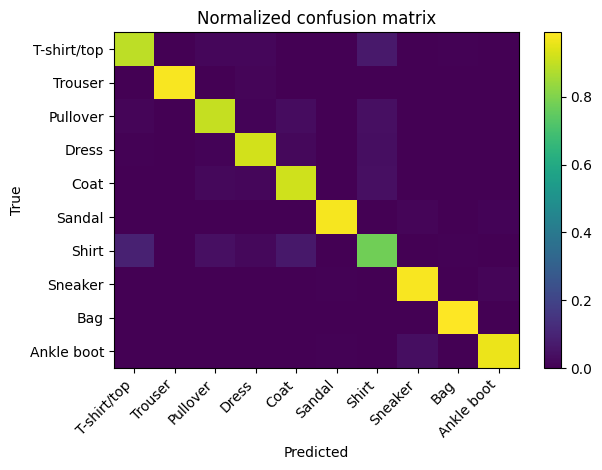

In [9]:
num_classes = 10
cm = np.zeros((num_classes, num_classes), dtype=np.int64)
for t, p in zip(all_labels, all_preds):
    cm[t, p] += 1

cm_norm = cm / cm.sum(axis=1, keepdims=True)

plt.figure()
plt.imshow(cm_norm, aspect='auto')
plt.xticks(range(num_classes), class_names, rotation=45, ha='right')
plt.yticks(range(num_classes), class_names)
plt.xlabel('Predicted'); plt.ylabel('True')
plt.title('Normalized confusion matrix'); plt.colorbar()
plt.tight_layout(); plt.show()

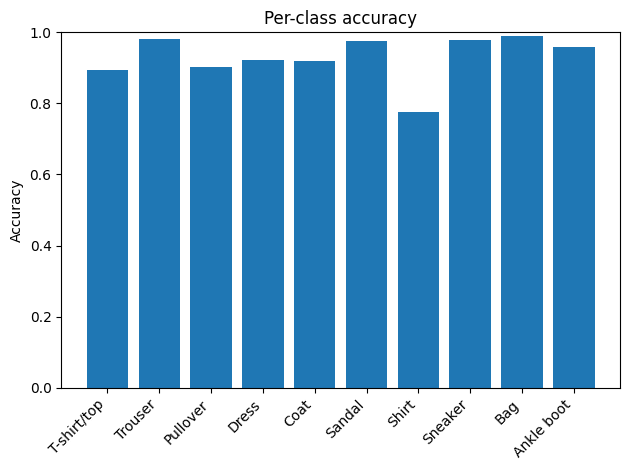

In [10]:
per_class_acc = (cm.diagonal() / cm.sum(axis=1)).tolist()

plt.figure()
plt.bar(range(num_classes), per_class_acc)
plt.xticks(range(num_classes), class_names, rotation=45, ha='right')
plt.ylim(0.0, 1.0)
plt.ylabel('Accuracy'); plt.title('Per-class accuracy')
plt.tight_layout(); plt.show()

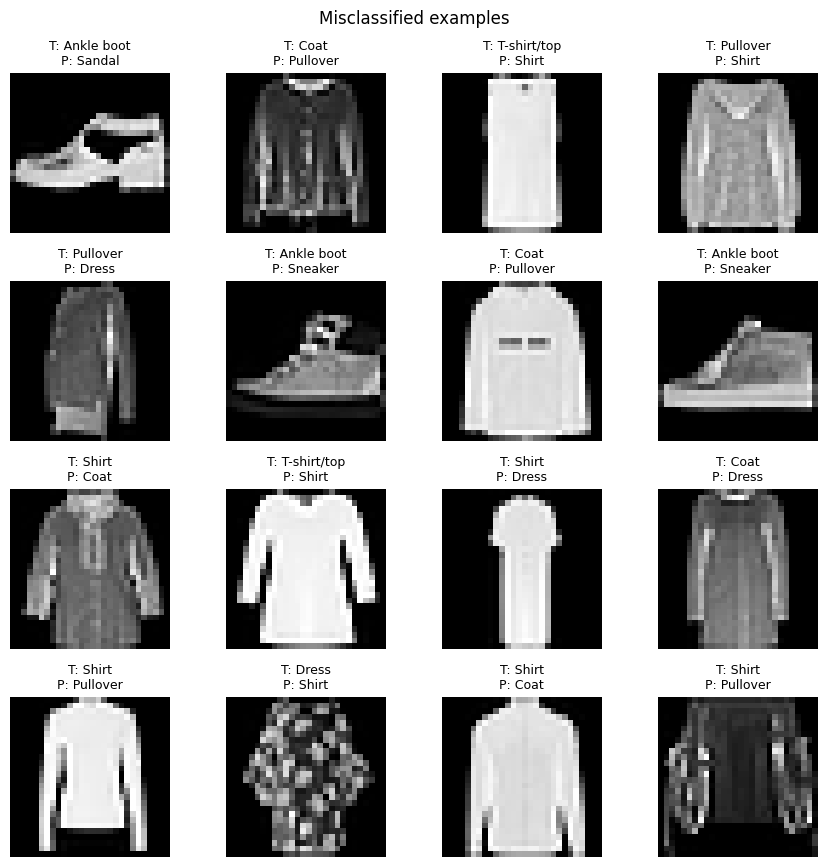

In [11]:
mis_images, mis_true, mis_pred = [], [], []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        preds = outputs.argmax(1)
        mismatch = preds != labels
        if mismatch.any():
            mis_images.append(images[mismatch].cpu())
            mis_true.append(labels[mismatch].cpu())
            mis_pred.append(preds[mismatch].cpu())
        if sum(x.size(0) for x in mis_images) >= 16:
            break

if mis_images:
    mis_images = torch.cat(mis_images)[:16]
    mis_true = torch.cat(mis_true)[:16]
    mis_pred = torch.cat(mis_pred)[:16]

    # denormalizace pro vykreslení
    mis_images = mis_images * FM_STD[0] + FM_MEAN[0]
    mis_images = mis_images.clamp(0, 1)

    n = mis_images.size(0); cols = 4; rows = int(np.ceil(n/cols))
    plt.figure(figsize=(cols*2.2, rows*2.2))
    for i in range(n):
        ax = plt.subplot(rows, cols, i+1)
        ax.imshow(mis_images[i].squeeze(0), cmap='gray')
        t = class_names[int(mis_true[i])]; p = class_names[int(mis_pred[i])]
        ax.set_title(f'T: {t}\nP: {p}', fontsize=9)
        ax.axis('off')
    plt.suptitle('Misclassified examples', y=0.98)
    plt.tight_layout(); plt.show()
else:
    print("Nenašel jsem chybně klasifikované snímky.")